# Set up environment & CSV input file

In [1]:
"""
    Summary
    ====================
    Import of libraries used in this project
        
"""

# Imports
import elasticsearch as es
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm, trange
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate,cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, classification_report,accuracy_score
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn import preprocessing
from sklearn.isotonic import IsotonicRegression
from datetime import datetime as dt

# ROC
import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection, svm

import math
import nltk
import re
import emoji 
import demoji
import time

#demoji.download_codes()
#nltk.download('punkt')

In [2]:
"""
    Summary
    ====================
    Load csv containing facebook user ids, Metadata, and classification (Bot/Not)
    
"""

# Load Publisher_ID CSV
df = pd.read_csv("inputList.csv") #read csv
df

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot
0,100009534802279,1,554,0,1,0,0,0,1,1
1,100009032616586,1,1835,307,0,1,0,0,0,0
2,100001912722840,1,0,508,1,0,1,1,0,0
3,1054155666,1,0,0,1,1,1,1,1,0
4,100040122383962,0,120,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
684,100058156613718,1,802,131,1,0,0,1,1,0
685,100028889356971,0,0,0,0,0,0,1,0,0
686,100013867175129,1,418,0,0,0,0,0,1,0
687,100014277696886,1,0,0,0,0,0,1,0,0


# Age Estimator

In [3]:
"""
    Summary
    ====================
    Extract estimated age from facebook id
        
"""
def estimate(clf, fbid):
    x_min = 1e14  # Before August 2009
    x_max = 1.0005e14 # After February 2020
    if int(fbid) < x.min():
        return 2008
    elif int(fbid) > x.max():
            return 2020
    else:
        result = round(clf.predict([fbid])[0])
        year = int(dt.fromtimestamp(result).strftime('%Y'))
        month = int(dt.fromtimestamp(result).strftime('%m'))
        joined = year + round((month-1)/12,2)
        return joined
    
fbid_age = pd.read_csv("facebook_age.csv") #read csv
x = fbid_age.fbid.values # ID
y = fbid_age.timestamp.values # Timestamp
clf = IsotonicRegression().fit(x, y)

df['Join_Year'] = 0.0
for index,row in df.iterrows():
    input_id = df.at[index,'Publisher_ID']
    date = estimate(clf, input_id)
    df.at[index,'Join_Year']=date

df

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot,Join_Year
0,100009534802279,1,554,0,1,0,0,0,1,1,2015.25
1,100009032616586,1,1835,307,0,1,0,0,0,0,2014.92
2,100001912722840,1,0,508,1,0,1,1,0,0,2011.00
3,1054155666,1,0,0,1,1,1,1,1,0,2008.00
4,100040122383962,0,120,0,0,0,1,0,1,1,2019.50
...,...,...,...,...,...,...,...,...,...,...,...
684,100058156613718,1,802,131,1,0,0,1,1,0,2020.00
685,100028889356971,0,0,0,0,0,0,1,0,0,2018.67
686,100013867175129,1,418,0,0,0,0,0,1,0,2016.75
687,100014277696886,1,0,0,0,0,0,1,0,0,2016.75


# Extract comments & posts from ElasticSearch

In [4]:
"""
    Summary
    ====================
    Extract Data from ElasticSearch
        
"""

# Server Connection Details
# The data used in this project is stored at private server which will not be available for github
server = es.Elasticsearch("Enter Server Info",timeout=120, max_retries=3, retry_on_timeout=True)

df['Comments']=""
df['Comments Amount']=0
df['Posts_ids']=""
df['Posts Amount']=0

# Query to server - for each user
for index,row in df.iterrows():
    # Query for data extraction
    body = {
      "query": {
        "bool": {
          "must": [],
          "filter": [
            {"match": {"type": "comment"}},
            {"match":{"Publisher_ID":df.at[index,'Publisher_ID']}}
          ]}}}
    
    # Commit Search Query
    res = server.search(index='posts_comments', body=body, size=10000, request_timeout=120, scroll='1m')
    time.sleep(0.01)
    
    # Save Result
    comments = []
    posts = []
    for comment in res['hits']['hits']:
        if isinstance(comment['_source']['Data'],str):
            comments.append(comment['_source']['Data'])
        if isinstance(comment['_source']['Post_ID'],int):
            if comment['_source']['Post_ID'] not in posts:
                posts.append(comment['_source']['Post_ID'])

    df.at[index,'Comments']=comments
    df.at[index,'Comments Amount']=len(comments)
    df.at[index,'Posts_ids']=posts
    df.at[index,'Posts Amount']=len(posts)
    
    df["Comments_Posts_Ratio"] = df['Comments Amount']/df['Posts Amount']
    
df.head(5)

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot,Join_Year,Comments,Comments Amount,Posts_ids,Posts Amount,Comments_Posts_Ratio
0,100009534802279,1,554,0,1,0,0,0,1,1,2015.25,"[כואב הלב 😔 יהי זכרה ברוך, אמן שהיא תעמוד בתפי...",7563,"[10156592496407076, 2404265086336959, 24068708...",569,13.291740
1,100009032616586,1,1835,307,0,1,0,0,0,0,2014.92,"[ברור שנגיע!🇮🇱🇮🇱, ''גנץ שיקר..."" ולדעתי לא בפע...",4383,"[10156814795882076, 10156812860997076, 1015682...",2744,1.597303
2,100001912722840,1,0,508,1,0,1,1,0,0,2011.00,"[אפשר עוד להציל את המדינה. בואו להצביע!!, לשתף...",5325,"[385212628822802, 385156662161732, 24685039267...",1771,3.006776
3,1054155666,1,0,0,1,1,1,1,1,0,2008.00,"[Kol Hakavod dear Bibi, No Text, Bibi The Only...",3814,"[10156583294222076, 386515832275318, 640265193...",1444,2.641274
4,100040122383962,0,120,0,0,0,1,0,1,1,2019.50,"[מקור בכיר במטה כחול לבן אמר היום "" אנחנו מבינ...",2490,"[383984985612233, 916207492084959, 27430980057...",1257,1.980907


# Extract Comments average length & standard deviation

In [5]:
# Iterate list of comments per each publisher
df['Comments_average_length'] = 0.0
df['Comments_std'] = 0.0

# Iterate df rows
for index,row in df.iterrows():
    publisher_comments=row['Comments']
    length_sum = 0
    comments_amount = len(publisher_comments)

    # Calculate total length of comments
    for comment in publisher_comments:
        length_sum +=len(comment)

    # Calculate average comment length
    length_average = length_sum / comments_amount

    # Calculate std
    std_sum = 0
    for comment in publisher_comments:
        std_sum += (abs(len(comment) - length_average))**2
    std = math.sqrt(std_sum/comments_amount)

    # Save to df
    df.at[index,'Comments_average_length']=length_average
    df.at[index,'Comments_std']=std
df

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot,Join_Year,Comments,Comments Amount,Posts_ids,Posts Amount,Comments_Posts_Ratio,Comments_average_length,Comments_std
0,100009534802279,1,554,0,1,0,0,0,1,1,2015.25,"[כואב הלב 😔 יהי זכרה ברוך, אמן שהיא תעמוד בתפי...",7563,"[10156592496407076, 2404265086336959, 24068708...",569,13.291740,47.364009,55.420421
1,100009032616586,1,1835,307,0,1,0,0,0,0,2014.92,"[ברור שנגיע!🇮🇱🇮🇱, ''גנץ שיקר..."" ולדעתי לא בפע...",4383,"[10156814795882076, 10156812860997076, 1015682...",2744,1.597303,85.542779,95.535741
2,100001912722840,1,0,508,1,0,1,1,0,0,2011.00,"[אפשר עוד להציל את המדינה. בואו להצביע!!, לשתף...",5325,"[385212628822802, 385156662161732, 24685039267...",1771,3.006776,12.449014,10.770516
3,1054155666,1,0,0,1,1,1,1,1,0,2008.00,"[Kol Hakavod dear Bibi, No Text, Bibi The Only...",3814,"[10156583294222076, 386515832275318, 640265193...",1444,2.641274,28.670163,37.619786
4,100040122383962,0,120,0,0,0,1,0,1,1,2019.50,"[מקור בכיר במטה כחול לבן אמר היום "" אנחנו מבינ...",2490,"[383984985612233, 916207492084959, 27430980057...",1257,1.980907,159.189157,287.275880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,100058156613718,1,802,131,1,0,0,1,1,0,2020.00,"[את הניה חיסלת?, והער.........בים?, 65 אחוז מב...",301,"[3983438655002386, 3793719494019707, 400773147...",272,1.106618,61.950166,57.612817
685,100028889356971,0,0,0,0,0,0,1,0,0,2018.67,"[No Text, אתה בלחץ אתה לא מקבל כל אחד אתה בוגד...",369,"[362830131306558, 2670166536329611, 2448568425...",168,2.196429,14.924119,20.442389
686,100013867175129,1,418,0,0,0,0,0,1,0,2016.75,[החבל מתהדק ביבי ושרה .הסכם עודפים ליברמן גנץ ...,373,"[10156583027542076, 2479692065443227, 10156574...",335,1.113433,106.981233,101.693922
687,100014277696886,1,0,0,0,0,0,1,0,0,2016.75,"[רק ביבי מנהג חזק בישראל,רק ביבי מלך בישראל, ר...",303,"[10157749192372076, 3785197048168602, 39594993...",206,1.470874,41.389439,25.417832


# Concatenate Comments

In [6]:
"""
    Summary
    ====================
    Concatenate Comments into a single string
        
"""
# Add column to df
df['Comments_Concatenated']=""

# Iterate df rows
for index,row in df.iterrows():

    # Concatenate comments into string
    text = ""
    for comment_str in df.at[index,'Comments']:
        text += comment_str
        text += " "
        
    #print(text)
    # Insert string into df
    df.at[index,'Comments_Concatenated']=text
    
# Save CSV
df.to_csv('data5.csv', sep='\t', encoding="utf-8-sig")

df.head(5)

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot,Join_Year,Comments,Comments Amount,Posts_ids,Posts Amount,Comments_Posts_Ratio,Comments_average_length,Comments_std,Comments_Concatenated
0,100009534802279,1,554,0,1,0,0,0,1,1,2015.25,"[כואב הלב 😔 יהי זכרה ברוך, אמן שהיא תעמוד בתפי...",7563,"[10156592496407076, 2404265086336959, 24068708...",569,13.291740,47.364009,55.420421,"כואב הלב 😔 יהי זכרה ברוך, אמן שהיא תעמוד בתפיל..."
1,100009032616586,1,1835,307,0,1,0,0,0,0,2014.92,"[ברור שנגיע!🇮🇱🇮🇱, ''גנץ שיקר..."" ולדעתי לא בפע...",4383,"[10156814795882076, 10156812860997076, 1015682...",2744,1.597303,85.542779,95.535741,"ברור שנגיע!🇮🇱🇮🇱 ''גנץ שיקר..."" ולדעתי לא בפעם ..."
2,100001912722840,1,0,508,1,0,1,1,0,0,2011.00,"[אפשר עוד להציל את המדינה. בואו להצביע!!, לשתף...",5325,"[385212628822802, 385156662161732, 24685039267...",1771,3.006776,12.449014,10.770516,אפשר עוד להציל את המדינה. בואו להצביע!! לשתף צ...
3,1054155666,1,0,0,1,1,1,1,1,0,2008.00,"[Kol Hakavod dear Bibi, No Text, Bibi The Only...",3814,"[10156583294222076, 386515832275318, 640265193...",1444,2.641274,28.670163,37.619786,Kol Hakavod dear Bibi No Text Bibi The Only Gr...
4,100040122383962,0,120,0,0,0,1,0,1,1,2019.50,"[מקור בכיר במטה כחול לבן אמר היום "" אנחנו מבינ...",2490,"[383984985612233, 916207492084959, 27430980057...",1257,1.980907,159.189157,287.275880,"מקור בכיר במטה כחול לבן אמר היום "" אנחנו מביני..."


# Unique Comments

In [7]:
"""
    Summary
    ====================
    Calculate how many of the comments are unique (not duplicated)
        
"""
df = pd.read_csv('data5.csv', index_col=0, sep='\t', encoding="utf-8-sig")

# Add column to df
df['Unique Comments']=0.0

# Iterate df rows
for index,row in df.iterrows():
    unique_comments = []
    for comment_str in df.at[index,'Comments']:
        if comment_str not in unique_comments:
            unique_comments.append(comment_str)
        
    # Insert string into df
    df.at[index,'Unique Comments']=len(unique_comments)/df.at[index,'Comments Amount']

df.head(5)

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot,Join_Year,Comments,Comments Amount,Posts_ids,Posts Amount,Comments_Posts_Ratio,Comments_average_length,Comments_std,Comments_Concatenated,Unique Comments
0,100009534802279,1,554,0,1,0,0,0,1,1,2015.25,"[""כואב הלב 😔 יהי זכרה ברוך, אמן שהיא תעמוד בתפ...",7563,"[10156592496407076, 2404265086336959, 24068708...",569,13.291740,47.364009,55.420421,"כואב הלב 😔 יהי זכרה ברוך, אמן שהיא תעמוד בתפיל...",0.035568
1,100009032616586,1,1835,307,0,1,0,0,0,0,2014.92,"['ברור שנגיע!🇮🇱🇮🇱', '\'\'גנץ שיקר..."" ולדעתי ל...",4383,"[10156814795882076, 10156812860997076, 1015682...",2744,1.597303,85.542779,95.535741,"ברור שנגיע!🇮🇱🇮🇱 ''גנץ שיקר..."" ולדעתי לא בפעם ...",0.047000
2,100001912722840,1,0,508,1,0,1,1,0,0,2011.00,"['אפשר עוד להציל את המדינה. בואו להצביע!!', 'ל...",5325,"[385212628822802, 385156662161732, 24685039267...",1771,3.006776,12.449014,10.770516,אפשר עוד להציל את המדינה. בואו להצביע!! לשתף צ...,0.018404
3,1054155666,1,0,0,1,1,1,1,1,0,2008.00,"['Kol Hakavod dear Bibi', 'No Text', 'Bibi The...",3814,"[10156583294222076, 386515832275318, 640265193...",1444,2.641274,28.670163,37.619786,Kol Hakavod dear Bibi No Text Bibi The Only Gr...,0.042475
4,100040122383962,0,120,0,0,0,1,0,1,1,2019.50,"['מקור בכיר במטה כחול לבן אמר היום "" אנחנו מבי...",2490,"[383984985612233, 916207492084959, 27430980057...",1257,1.980907,159.189157,287.275880,"מקור בכיר במטה כחול לבן אמר היום "" אנחנו מביני...",0.044578


# Extract Emojis

In [8]:
"""
    Summary
    ====================
    Extract list of Emojis from the comments
        
"""
# Add Emojis column
df['Emojis']=""

# Append emojis dictionary
for index,row in df.iterrows():
    emojis = []
    emojis.append(demoji.findall(df.at[index,'Comments_Concatenated']))
    df.at[index,'Emojis']=emojis
    
df['Emojis_Count']=0

# Create column for each emoji
for row_index in df.index:
    for emoji in df.loc[row_index]['Emojis'][0]:
        df[emoji]=0

# Count each emoji for each user
for row_index in df.index: # Iterate users
    total_counter = 0
    
    for emoji in df.loc[row_index]['Emojis'][0]: # Iterate emojis
        cur_counter = df.loc[row_index]['Comments_Concatenated'].count(emoji) # Count emojis
        df.at[row_index,emoji]=cur_counter # Set amount of current emoji
        total_counter += cur_counter
        
    df.at[row_index,'Emojis_Count']=total_counter # Set Total emojis count

df2 = df # Save stage
df.head(5)

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot,...,🚽,🦗,👧,⚠,🦓,😽,🦌,🤟🏿,👦,🤘🏿
0,100009534802279,1,554,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,100009032616586,1,1835,307,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,100001912722840,1,0,508,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1054155666,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,100040122383962,0,120,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


# Extract Links

In [9]:
"""
    Summary
    ====================
    Extract amount of links from the comments
        
"""
df = df2 # Continue Stage

# Add Links column
df['Links_Count']=0

# Count each link for each user
for row_index in df.index: # Iterate users
    cur_counter = df.loc[row_index]['Comments_Concatenated'].count(' http')
    cur_counter += df.loc[row_index]['Comments_Concatenated'].count(' www')
    df.at[row_index,'Links_Count']=cur_counter # Set amount of current links
        
df.head(5)

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot,...,🦗,👧,⚠,🦓,😽,🦌,🤟🏿,👦,🤘🏿,Links_Count
0,100009534802279,1,554,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,6
1,100009032616586,1,1835,307,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
2,100001912722840,1,0,508,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,2
3,1054155666,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,100040122383962,0,120,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,31


# Extract Punctuation 

In [10]:
"""
    Summary
    ====================
    Count vectorize only punctuation
        
"""
def markCounter(df, mark): # add specifit string count to df
    df[mark]=0
    for row_index in df.index: # Iterate users
        cur_counter = df.loc[row_index]['Comments_Concatenated'].count(mark)
        df.at[row_index,mark]=cur_counter # Set amount of current mark

# Count those marks:
markCounter(df,',')
markCounter(df,'!')
markCounter(df,'?')
markCounter(df,'.')
markCounter(df,'"')
markCounter(df,'@')
markCounter(df,'*')
markCounter(df,'/')
markCounter(df,'(')
markCounter(df,')')
markCounter(df,':')

df.head(5)

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot,...,!,?,.,"""",@,*,/,(,),:
0,100009534802279,1,554,0,1,0,0,0,1,1,...,2575,343,3814,297,0,1,47,64,71,77
1,100009032616586,1,1835,307,0,1,0,0,0,0,...,6193,405,6041,315,1,141,1191,135,140,610
2,100001912722840,1,0,508,1,0,1,1,0,0,...,1280,19,515,16,0,0,15,2,1,5
3,1054155666,1,0,0,1,1,1,1,1,0,...,1082,4,595,45,0,0,0,3,3,1
4,100040122383962,0,120,0,0,0,1,0,1,1,...,116,193,2741,931,0,3452,259,125,107,452


# Clean Comments_Concatenated

In [11]:
"""
    Summary
    ====================
    Clean comments from not-letters (or numbers) symbols, so we will get a clean text
        
"""
# ------------------- Expressions To Remove!
def clean_text(rgx_list, text,char):
    new_text = text
    for rgx_match in rgx_list:
        new_text = re.sub(rgx_match, char, new_text)
    return new_text

df['Comments_Concatenated_Cleaned']=""

# Tokenize Regex Patterns

rgx_list1 = [
# Links
    'https:\/\/.* ', 
    'http:\/\/.* ', 
    'www\..* ', 
    '[a-z]*\.co.*\/.* ', 
    'https:\/\/.*\n', 
    'http:\/\/.*\n', 
    'www\..*\n', 
    '[a-z]*\.co.*\/.*\n', 
# Facebook addons
    'No Text', 
    'See more',
    'See More'
]

rgx_list2 = [
# Metacharacters
    '\?', "\.", "\…", "\,", "\!", "\n", "\"", "\״", "\’", "\@", "\:", "\-", "\*", "\/", "\(", "\)", "\|", "\'",
# Numbers
    "[0-9]"]

rgx_list3= [
    # Keep letters only
    "[^א-תa-zA-Z ]"
]

rgx_list4= [
    # Single chars
    " . "
]

rgx_list5= [
    # Spaces
    "\s\s*",
]

# Apply
for index,row in df.iterrows():
    df.at[index,'Comments_Concatenated_Cleaned']=clean_text(rgx_list1, df.at[index,'Comments_Concatenated'],' ')
    df.at[index,'Comments_Concatenated_Cleaned']=clean_text(rgx_list2, df.at[index,'Comments_Concatenated_Cleaned'],' ')
    df.at[index,'Comments_Concatenated_Cleaned']=clean_text(rgx_list3, df.at[index,'Comments_Concatenated_Cleaned'],'')
    df.at[index,'Comments_Concatenated_Cleaned']=clean_text(rgx_list4, df.at[index,'Comments_Concatenated_Cleaned'],' ')
    df.at[index,'Comments_Concatenated_Cleaned']=clean_text(rgx_list5, df.at[index,'Comments_Concatenated_Cleaned'],' ')
    
df3 = df
    
df.head(5)

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot,...,?,.,"""",@,*,/,(,),:,Comments_Concatenated_Cleaned
0,100009534802279,1,554,0,1,0,0,0,1,1,...,343,3814,297,0,1,47,64,71,77,כואב הלב יהי זכרה ברוך אמן שהיא תעמוד בתפילה ל...
1,100009032616586,1,1835,307,0,1,0,0,0,0,...,405,6041,315,1,141,1191,135,140,610,ברור שנגיע גנץ שיקר ולדעתי לא בפעם הראשונה אכן...
2,100001912722840,1,0,508,1,0,1,1,0,0,...,19,515,16,0,0,15,2,1,5,אפשר עוד להציל את המדינה בואו להצביע לשתף צאו ...
3,1054155666,1,0,0,1,1,1,1,1,0,...,4,595,45,0,0,0,3,3,1,Kol Hakavod dear Bibi Bibi The Only Greater PM...
4,100040122383962,0,120,0,0,0,1,0,1,1,...,193,2741,931,0,3452,259,125,107,452,מקור בכיר במטה כחול לבן אמר היום אנחנו מבינים ...


# Check for language

In [12]:
df['is_eng']=0
df['is_heb']=0
eng = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
heb = ['א','ב','ג','ד','ה','ו','ז','ח','ט','י','כ','ל','מ','נ','ס','ע','פ','צ','ק','ר','ש','ת']
for index,row in df.iterrows():
    eng_flag = False
    heb_flag = False
    for c in eng:
        if c in df.at[index,'Comments_Concatenated_Cleaned']:
            eng_flag = True
    for c in heb:
        if c in df.at[index,'Comments_Concatenated_Cleaned']:
            heb_flag = True
    if eng_flag:
        df.at[index,'is_eng']=1
    if heb_flag:
        df.at[index,'is_heb']=1

# Tokenize

In [13]:
"""
    Summary
    ====================
    Tokenize comments
        
"""
df = df3

# Add Tokenized column (Includes Emojis)
df['Tokenized']=""
df['Total Words']=0.0

# Append to Tokenized column
for index,row in df.iterrows():
    df.at[index,'Tokenized']=nltk.word_tokenize(df.at[index,'Comments_Concatenated_Cleaned'])
    df.at[index,'Total Words']=len(df.at[index,'Tokenized'])

df4 = df

df.head(5)

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot,...,*,/,(,),:,Comments_Concatenated_Cleaned,is_eng,is_heb,Tokenized,Total Words
0,100009534802279,1,554,0,1,0,0,0,1,1,...,1,47,64,71,77,כואב הלב יהי זכרה ברוך אמן שהיא תעמוד בתפילה ל...,1,1,"[כואב, הלב, יהי, זכרה, ברוך, אמן, שהיא, תעמוד,...",64483.0
1,100009032616586,1,1835,307,0,1,0,0,0,0,...,141,1191,135,140,610,ברור שנגיע גנץ שיקר ולדעתי לא בפעם הראשונה אכן...,1,1,"[ברור, שנגיע, גנץ, שיקר, ולדעתי, לא, בפעם, הרא...",43091.0
2,100001912722840,1,0,508,1,0,1,1,0,0,...,0,15,2,1,5,אפשר עוד להציל את המדינה בואו להצביע לשתף צאו ...,1,1,"[אפשר, עוד, להציל, את, המדינה, בואו, להצביע, ל...",3059.0
3,1054155666,1,0,0,1,1,1,1,1,0,...,0,0,3,3,1,Kol Hakavod dear Bibi Bibi The Only Greater PM...,1,1,"[Kol, Hakavod, dear, Bibi, Bibi, The, Only, Gr...",9977.0
4,100040122383962,0,120,0,0,0,1,0,1,1,...,3452,259,125,107,452,מקור בכיר במטה כחול לבן אמר היום אנחנו מבינים ...,0,1,"[מקור, בכיר, במטה, כחול, לבן, אמר, היום, אנחנו...",1085.0


# Unique Words

In [14]:
"""
    Summary
    ====================
    Count how many of the words are unique per each user
        
"""
df = df4
df["Unique Words"]=0
df["Unique Words Ratio"]=0.0
for row_index in df.index: # Iterate users
    unique = set(df.loc[row_index]['Tokenized']) 
    df.at[row_index,"Unique Words"]=len(unique) # Set amount of unique words

df["Unique Words Ratio"]= (df["Total Words"]) / (df["Unique Words"]+1)
    
df5 = df
df.head(5)

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot,...,(,),:,Comments_Concatenated_Cleaned,is_eng,is_heb,Tokenized,Total Words,Unique Words,Unique Words Ratio
0,100009534802279,1,554,0,1,0,0,0,1,1,...,64,71,77,כואב הלב יהי זכרה ברוך אמן שהיא תעמוד בתפילה ל...,1,1,"[כואב, הלב, יהי, זכרה, ברוך, אמן, שהיא, תעמוד,...",64483.0,7374,8.743458
1,100009032616586,1,1835,307,0,1,0,0,0,0,...,135,140,610,ברור שנגיע גנץ שיקר ולדעתי לא בפעם הראשונה אכן...,1,1,"[ברור, שנגיע, גנץ, שיקר, ולדעתי, לא, בפעם, הרא...",43091.0,2871,15.003830
2,100001912722840,1,0,508,1,0,1,1,0,0,...,2,1,5,אפשר עוד להציל את המדינה בואו להצביע לשתף צאו ...,1,1,"[אפשר, עוד, להציל, את, המדינה, בואו, להצביע, ל...",3059.0,522,5.848948
3,1054155666,1,0,0,1,1,1,1,1,0,...,3,3,1,Kol Hakavod dear Bibi Bibi The Only Greater PM...,1,1,"[Kol, Hakavod, dear, Bibi, Bibi, The, Only, Gr...",9977.0,1816,5.490919
4,100040122383962,0,120,0,0,0,1,0,1,1,...,125,107,452,מקור בכיר במטה כחול לבן אמר היום אנחנו מבינים ...,0,1,"[מקור, בכיר, במטה, כחול, לבן, אמר, היום, אנחנו...",1085.0,558,1.940966


# Count Vectorizer

In [15]:
"""
    Summary
    ====================
    Transforms comment string to columns per each word in the comment
        
"""
df = df5
# Count Vectorize Object - Set max features
cv = CountVectorizer(max_features=10000)

# Fit words
X = cv.fit_transform(df['Comments_Concatenated_Cleaned'])

# Add to df
words_df = pd.DataFrame(columns=cv.get_feature_names(),data=X.toarray())
df = df.join(words_df)

df.head(5)

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot,...,תתנו,תתעורר,תתעוררו,תתעלם,תתעסק,תתפוצצו,תתפטר,תתפטרי,תתקדם,תתקשר
0,100009534802279,1,554,0,1,0,0,0,1,1,...,0,0,0,9,0,0,0,0,0,0
1,100009032616586,1,1835,307,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,100001912722840,1,0,508,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1054155666,1,0,0,1,1,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
4,100040122383962,0,120,0,0,0,1,0,1,1,...,1,0,0,0,0,0,0,0,0,0


In [16]:
# Sorted Output
mat = zip(cv.get_feature_names(), np.asarray(X.sum(axis=0)).ravel())
mat = list(mat)
mat=sorted(mat, key = lambda x: x[1],reverse=True)
for tup in mat:
    print(tup[0],' - ',round(tup[1],3))

את  -  91628
לא  -  73123
ביבי  -  52353
על  -  46523
של  -  43628
זה  -  37282
רק  -  36386
כל  -  33594
עם  -  30205
אתה  -  26852
ישראל  -  24854
לך  -  24550
מה  -  22703
ראש  -  19824
אין  -  18276
הממשלה  -  18091
הוא  -  16984
מלך  -  15281
אני  -  14864
יש  -  14191
אותך  -  13667
גם  -  13052
מחל  -  12795
נתניהו  -  12775
מי  -  11990
טוב  -  11688
שלך  -  11446
אם  -  11408
ממשלה  -  11067
אנחנו  -  10994
לנו  -  10711
שלנו  -  10329
ולא  -  10134
המדינה  -  10088
הם  -  10042
בנט  -  9934
כי  -  9610
גנץ  -  9561
שלא  -  9434
תודה  -  9404
לי  -  9295
אחד  -  8940
כמו  -  8506
או  -  8385
הכבוד  -  8385
עוד  -  8290
היה  -  8207
ליברמן  -  8098
כבר  -  7903
יותר  -  7876
לו  -  7820
הליכוד  -  7495
אבל  -  7196
בכל  -  7062
אתם  -  6939
שלום  -  6884
שלי  -  6866
כך  -  6785
כמה  -  6609
היא  -  6542
הכל  -  6423
אז  -  6366
להיות  -  6311
בהצלחה  -  6274
הזה  -  6261
צריך  -  6185
להם  -  6141
אוהבים  -  6083
למה  -  6076
שאתה  -  5930
עד  -  5919
יום  -  5845
כדי  -  5698

# Drop Stop Words Columns

In [17]:
"""
    Summary
    ====================
    Removes stop words columns
        
"""
# Stop Words List
sub_stop_words = ['לא','על','של','רק','כל','עם','מה','מי','למה','איך','איפה','מדוע','מתי','כמה','זה','או','גם','אם','זה','זאת','אני','את','אתה','אנחנו','הם','הן','אתם','תן','לי','לו','לך','לנו','יש','אין','כי','עוד','כמו','היה','יותר','כך','אל','פה','שם']
dropped = []

# Search Stop Words
for col in df.columns:
    for word in sub_stop_words:
        if word in col and len(word)+2 >= len(col):
            dropped.append(col)
            
# Remove Duplicates
dropped = list(dict.fromkeys(dropped))

print('Stop Words Removed: ',len(dropped))

# Drop Stop Words
for word in dropped:
    df = df.drop(word, axis = 1)
    
df_t1 = df

Stop Words Removed:  822


# Normalize columns

Drop Irrelevant Columns

In [18]:
"""
    Summary
    ====================
    Drop irrelevant columns for learning and split train test
        
"""
df = df_t1

# Set prediction column
y_set = df['Bot']

# Drop irrelevant columns
X_set = df.drop(axis=0,columns=['Publisher_ID','Bot','Comments','Comments_Concatenated','Emojis','Comments_Concatenated_Cleaned','Tokenized','Posts_ids'])

Minmax Normalize

In [19]:
"""
    Summary
    ====================
    Minmax normalize the columns
        
"""
# Normalize

# Columns to scale without L2
NotToScale = ['Comments Amount','Posts Amount','Comments_Posts_Ratio','Unique Comments','Emojis_Count','Links_Count','Unique Words','Total Words','Unique Words Ratio','Image','Friends','Followers','Sticker','Political_Profile_Pic','Tricky_Name','Political_Feed','Join_Year','Has_username','Comments_average_length','Comments_std','is_eng','is_heb']
#NotToScale = ['Comments Amount','Posts Amount','Comments_Posts_Ratio','Unique Comments','Emojis_Count','Links_Count','Unique Words','Total Words','Unique Words Ratio','Join_Year','Comments_average_length','Comments_std','is_eng','is_heb']
NotToScaleSet = X_set[NotToScale]

# Columns to scale with L2
ToScaleSet = X_set.drop(axis=1,columns=NotToScale)
transformer = Normalizer(norm='l2').fit(ToScaleSet)
ToScaleSet = pd.DataFrame(transformer.transform(ToScaleSet),columns=ToScaleSet.columns)

# Minmax 
NotToScaleSet=(NotToScaleSet-NotToScaleSet.min())/(NotToScaleSet.max()-NotToScaleSet.min()) #MinMax

# Combine sets
X_set = result = pd.concat([ToScaleSet, NotToScaleSet], axis=1)
X_set


,🔥,😘,😔,🤴🏻,🤦‍♂️,‼️,🍷,🇮🇱,🥰,👑,...,Sticker,Political_Profile_Pic,Tricky_Name,Political_Feed,Join_Year,Has_username,Comments_average_length,Comments_std,is_eng,is_heb
0,0.002402,0.005173,0.001293,0.000369,0.001108,0.000369,0.001478,0.061150,0.002032,0.011639,...,1.0,0.0,0.0,1.0,0.600166,0.0,0.052112,0.051616,1.0,1.0
1,0.000000,0.000000,0.000628,0.000000,0.000000,0.000000,0.006027,0.703191,0.000000,0.015947,...,0.0,1.0,0.0,0.0,0.572848,0.0,0.095496,0.089244,1.0,1.0
2,0.000619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011142,...,1.0,0.0,1.0,0.0,0.248344,1.0,0.012436,0.009735,1.0,1.0
3,0.000000,0.013903,0.000000,0.000000,0.000000,0.000000,0.000000,0.001395,0.001209,0.602902,...,1.0,1.0,1.0,1.0,0.000000,1.0,0.030869,0.034919,1.0,1.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,1.0,0.951987,0.0,0.179184,0.269095,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,1.0,0.993377,1.0,0.068687,0.053672,1.0,1.0
685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044369,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.883278,1.0,0.015249,0.018807,1.0,1.0
686,0.000000,0.000000,0.000000,0.000000,0.000000,0.009052,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.0,0.724338,0.0,0.119858,0.095020,1.0,1.0
687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.724338,1.0,0.045323,0.023474,0.0,1.0


# Random Forest Classifier

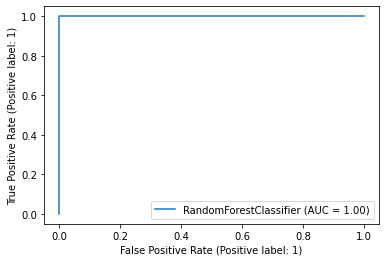

RFC Results:

Accuracy Score: 0.8258345428156749 

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.98      0.90       567
           1       0.54      0.11      0.19       122

    accuracy                           0.83       689
   macro avg       0.69      0.55      0.55       689
weighted avg       0.78      0.83      0.78       689

Confusion Matrix:
 [[555  12]
 [108  14]]


In [21]:
"""
    Summary
    ====================
    fit Random Forest Classifier model and print evaluation results
        
"""
# Model
rfc = RandomForestClassifier(n_estimators=128, random_state=0 ,class_weight='balanced')

# Fit (Cross Validation)
rfc.fit(X_set, y_set)
folds = 10
y_pred = cross_val_predict(rfc, X_set, y_set, cv=folds)

# Display ROC
metrics.plot_roc_curve(rfc, X_set, y_set)  
plt.show()

# Evaluate
print("RFC Results:\n")
print("Accuracy Score:",accuracy_score(y_set,y_pred),"\n")
print("Classification Report:\n",classification_report(y_set, y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_set,y_pred))

# SVM rbf kernel

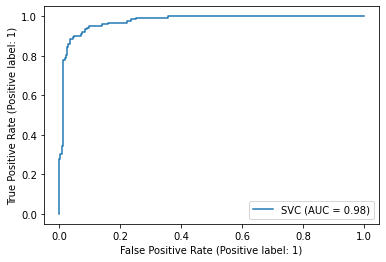

SVM Classifier Results:

Accuracy Score: 0.8316400580551524 

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89       567
           1       0.52      0.84      0.64       122

    accuracy                           0.83       689
   macro avg       0.74      0.83      0.76       689
weighted avg       0.88      0.83      0.85       689

Confusion Matrix:
 [[471  96]
 [ 20 102]]


In [22]:
"""
    Summary
    ====================
    fit SVM model and print evaluation results

"""
# Model
svm1 = svm.SVC(C=1.2,class_weight='balanced', probability = True, kernel = 'rbf')

# Fit (Cross Validation)
svm1.fit(X_set, y_set)
folds = 7
y_pred = cross_val_predict(svm1, X_set, y_set, cv=folds)

# Display ROC
metrics.plot_roc_curve(svm1, X_set, y_set)
plt.show()

# Evaluate
print("SVM Classifier Results:\n")
print("Accuracy Score:",accuracy_score(y_set,y_pred),"\n")
print("Classification Report:\n",classification_report(y_set, y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_set,y_pred))

# SVM Linear Kernel

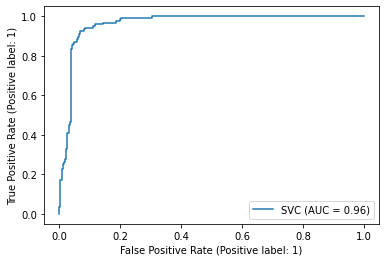

SVM Classifier Results:

Accuracy Score: 0.8258345428156749 

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.89       567
           1       0.51      0.79      0.62       122

    accuracy                           0.83       689
   macro avg       0.73      0.81      0.75       689
weighted avg       0.87      0.83      0.84       689

Confusion Matrix:
 [[473  94]
 [ 26  96]]


In [23]:
"""
    Summary
    ====================
    fit SVM model and print evaluation results
        
"""
# Model
clf_l = svm.SVC(C=1.2,class_weight='balanced', probability = True, kernel = 'linear')

# Fit (Cross Validation)
clf_l.fit(X_set, y_set)
folds = 7
y_pred = cross_val_predict(clf_l, X_set, y_set, cv=folds)

# Display ROC
metrics.plot_roc_curve(clf_l, X_set, y_set)  
plt.show()

# Evaluate
print("SVM Classifier Results:\n")
print("Accuracy Score:",accuracy_score(y_set,y_pred),"\n")
print("Classification Report:\n",classification_report(y_set, y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_set,y_pred))

# MultinomialNB

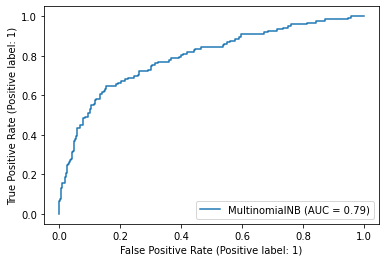

NaiveBayes Classifier Results:

Accuracy Score: 0.8050847457627118 

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       350
           1       0.63      0.59      0.61       122

    accuracy                           0.81       472
   macro avg       0.75      0.74      0.74       472
weighted avg       0.80      0.81      0.80       472

Confusion Matrix:
 [[308  42]
 [ 50  72]]


In [24]:
"""
    Summary
    ====================
    fit MultinomialNB model and print evaluation results
        
"""
# Balanced Dataset
Balanced_y = y_set[y_set==0][:350].append(y_set[y_set==1][:])
Balanced_X = X_set[y_set==0][:350].append(X_set[y_set==1][:])
Balanced_X.reset_index()
Balanced_y.reset_index()

# Model
clf_m = MultinomialNB(class_prior = (1,350))
clf_m.fit(X_set, y_set)

# Fit (Cross Validation)
folds = 15
y_pred = cross_val_predict(clf_m, Balanced_X, Balanced_y, cv=folds)
#y_pred = cross_val_predict(clf_m, X_set, y_set, cv=folds)

# Display ROC
metrics.plot_roc_curve(clf_m, X_set, y_set)  
plt.show()

# Evaluate
print("NaiveBayes Classifier Results:\n")
print("Accuracy Score:",accuracy_score(Balanced_y,y_pred),"\n")
print("Classification Report:\n",classification_report(Balanced_y, y_pred))
print("Confusion Matrix:\n",confusion_matrix(Balanced_y,y_pred))

# SVM 'predict_proba'

In [25]:
# Model
svm_p = svm.SVC(C=1.2,class_weight='balanced', probability=True)

# Fit (Cross Validation)
svm_p.fit(X_set, y_set)
folds = 7
y_pred2 = cross_val_predict(svm_p, X_set, y_set, cv=folds, method='predict_proba')

In [26]:
"""
    Summary
    ====================
    evaluate prediction correct precentage, compare to the models probability
        
"""
def evaluation(minimum, maximum, y_pred, y_set,value):
    not_bot = 0
    bot = 0
    for i in y_set[(y_pred[:,value]>=minimum) & (y_pred[:,value]<maximum)]:
        if i==0:
            not_bot+=1
        else:
            bot+=1 
    print('Total:\t',not_bot+bot)
    print('Probability Range:\t',minimum,'-', maximum)
    per = round(not_bot*100/(not_bot+bot),1)
    print('Not Bot:',not_bot,' (',per,'%)')
    per = round(bot*100/(not_bot+bot),1)
    print('Bot:\t',bot,' (',per,'%)\n')
    
# Evaluattion
print("When the prediction is Bot:\n")
evaluation(0,0.5,y_pred2,y_set,1)
evaluation(0.5,0.75,y_pred2,y_set,1)
evaluation(0.75,1,y_pred2,y_set,1)

print("When the prediction is Not-Bot:\n")
evaluation(0,0.5,y_pred2,y_set,0)
evaluation(0.5,0.75,y_pred2,y_set,0)
evaluation(0.75,1,y_pred2,y_set,0)

When the prediction is Bot:

Total:	 591
Probability Range:	 0 - 0.5
Not Bot: 538  ( 91.0 %)
Bot:	 53  ( 9.0 %)

Total:	 63
Probability Range:	 0.5 - 0.75
Not Bot: 25  ( 39.7 %)
Bot:	 38  ( 60.3 %)

Total:	 35
Probability Range:	 0.75 - 1
Not Bot: 4  ( 11.4 %)
Bot:	 31  ( 88.6 %)

When the prediction is Not-Bot:

Total:	 96
Probability Range:	 0 - 0.5
Not Bot: 28  ( 29.2 %)
Bot:	 68  ( 70.8 %)

Total:	 87
Probability Range:	 0.5 - 0.75
Not Bot: 55  ( 63.2 %)
Bot:	 32  ( 36.8 %)

Total:	 506
Probability Range:	 0.75 - 1
Not Bot: 484  ( 95.7 %)
Bot:	 22  ( 4.3 %)



# Result Evaluation

Predicted as Bot but labeled Not-Bot

In [60]:
# Bot High Probability
nbi = df[y_pred2[:,1]>0.75].index
# Not Bot
bi = df[y_set==0].index
# Index Lisst
ilb = []
for i in df.index:
    if (i in nbi) and (i in bi):
        ilb.append(i)
df.iloc[ilb]

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot,...,תתנו,תתעורר,תתעוררו,תתעלם,תתעסק,תתפוצצו,תתפטר,תתפטרי,תתקדם,תתקשר
184,100030739792343,1,141,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
273,100011374085616,0,225,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
558,100010556710026,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
634,100045698850700,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Examine comments
indx = 634
print('User: ',df.iloc[indx]['Publisher_ID'],'\n\n')
print(df.iloc[indx]['Comments'])

User:  100045698850700 


['Good going Bibi', 'Bless Israel and bless Bibi', 'Bless Bibi Bless Israel', 'Bless her prayers for the fsmily', 'Bless you', 'Bless Bibi', 'Bless you', 'Good luck Bibi', 'God bless Bibi', 'Bless Bibi bless Israel', 'Shabbat shalom', 'Blessings', 'Bibi is a great Prime minister', 'Bless Israel bless Bibi', 'Prayers for Jerusalem', 'God bless Israel', 'You have to defend yourselves', 'Blessings', 'Blessings', 'Blessings', 'Amen bless you and your people', 'Best of luck', 'Blessings and prayers', 'Prayers for peace of Jerusalem', 'Blessings', 'Blessings', 'Blessings for you and your family', 'Amen blessings', 'Prayers', 'Blessings', 'Blessings', 'God loves Israel', 'Blessings and prayers for Israel', 'Keep the strength Bibi good going', 'Blessings', 'Amen Prime minister', 'Prayers for bibi', 'God bless Israel and Bibi', 'Way to go Bibi', 'Never forget', 'Forget them keep on Bibi', 'Thank you Bibi blessings to you and your nation', 'Bless Bibi bless Israel', 'Bl

Predicted as Not-Bot but labeled Bot

In [77]:
# Not Bot High Probability
nbi = df[y_pred2[:,0]>0.95].index
# Bot
bi = df[y_set==1].index
# Index Lisst
ilnb = []
for i in df.index:
    if (i in nbi) and (i in bi):
        ilnb.append(i)
df.iloc[ilnb]

,Publisher_ID,Image,Friends,Followers,Sticker,Political_Profile_Pic,Tricky_Name,Has_username,Political_Feed,Bot,...,תתנו,תתעורר,תתעוררו,תתעלם,תתעסק,תתפוצצו,תתפטר,תתפטרי,תתקדם,תתקשר
154,100052271058979,1,543,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
155,100015116321541,1,13,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
218,100028690818298,1,34,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
360,100006655006371,1,4968,0,1,0,0,0,1,1,...,0,1,0,0,0,0,2,0,0,0
381,100003366603269,1,98,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
477,100001895197379,1,0,0,1,0,0,0,1,1,...,0,0,0,0,1,1,0,0,0,0


In [75]:
# Examine comments
indx = 168
print('User: ',df.iloc[indx]['Publisher_ID'],'\n\n')
print(df.iloc[indx]['Comments'])

User:  100000444773377 


['מה לגבי החוקים ההזויים שאתם רוצים להכניס ? בשביל זה נכנסתם ?', 'שום מילה על משפט נתניהו ?', 'פשוט לא נשאר מה לומר.', 'נבל. אז למה התעקשת למנות אותו ליועמש אם ככה ? אי אפשר להאמין לך למילה', 'אם בגץ יפסול את ביבי מלכהן כממלא מקום ראש הממשלה סיכמתם שנצא לבחירות ?מה נרוויח מזה ? ביבי יגיד "בגץ אשם" ולכם לא תהיה לזה תגובה. תדרשו מביבי להסכים למועמד אחד מהליכוד במקרה כזה,ואם לא יסכים,תהיה לכם סיבה להאשים אותו בבחירות נוספות !', 'עוד פייק. פורבס אמרו שזה לא דירוג שלהם. הם נותנים לבלוגים שונים לפרסם מאמרים באתר שלהם. מי שפירסם את זה זו חברה מהונג קונג עם 10 אנשים. דיי לשקר ולזלזל באזרחי ישראל', 'אוי מסכן. אין לך מספיק כסף בחשבון ?גם לנו.', 'יאיר ! בבקשה מכם,אם גנץ נכנס אל תישארו בחוץ. בבקשה.', 'הם עומדים במרחק אחד מהשני כדי לשמור על החוק,בניגוד אלייך. חצוף.', 'הכנסת אותנו לסגר. מפתיע למה אין הרבה מתים וחולים (תודה לאל)  . עכשיו תראה לנו שיש לך תכנית ליציאה כי הכלכלה שלנו קורסת', 'בגלל סעיף כזה או אחר ,שימלט אותך מהמשפט, במשא ומתן מול גנץ אתה רוצה לקחת אותנו לבחירות

# Common Words

Get Bot word list

In [31]:
dfc = df[df['Bot']==1]

cv2 = CountVectorizer(max_features=5000)

# Fit words
X2 = cv2.fit_transform(dfc['Comments_Concatenated_Cleaned'])

# Sorted Output
mat2 = zip(cv2.get_feature_names(), np.asarray(X2.sum(axis=0)).ravel())
mat2 = list(mat2)
mat2=sorted(mat2, key = lambda x: x[1],reverse=True)

bot_words = [] # array for bot words
for tup in mat2:
    if tup[0] not in sub_stop_words:
        bot_words.append(tup)
        print(tup[0],' - ',round(tup[1],3))

ביבי  -  10556
ישראל  -  6278
מחל  -  5355
טוב  -  4158
ראש  -  4104
הממשלה  -  3579
אותך  -  3185
מלך  -  2970
הוא  -  2933
תודה  -  2767
ליברמן  -  2711
בבקשה  -  2495
בכם  -  2480
יום  -  2429
טעינו  -  2376
שלחמנו  -  2371
שלום  -  2267
בכל  -  2235
לתקן  -  2156
הטעות  -  2146
ממשלה  -  2092
נתניהו  -  2091
העולם  -  2017
חובה  -  1994
שלנו  -  1968
ולא  -  1879
סליחה  -  1804
הכבוד  -  1785
de  -  1756
גנץ  -  1727
israel  -  1681
שלא  -  1639
המדינה  -  1631
to  -  1589
בנט  -  1498
נגד  -  1455
כולם  -  1449
אחד  -  1441
לפיד  -  1411
מאוד  -  1403
להם  -  1390
הכל  -  1386
שלך  -  1386
god  -  1378
bibi  -  1340
boa  -  1326
sorte  -  1326
בהצלחה  -  1251
הזה  -  1250
עד  -  1248
מירי  -  1224
אסור  -  1213
אבל  -  1206
עליך  -  1206
כבר  -  1195
que  -  1169
ללא  -  1167
אוהבים  -  1156
הזמן  -  1155
שלו  -  1151
פעם  -  1140
להיות  -  1134
ואת  -  1127
היא  -  1123
לכל  -  1122
לקבוצה  -  1111
bless  -  1103
אלוהים  -  1101
חייבים  -  1085
אמן  -  1082
אותנו  -  1080
כדי  - 

Get Not-Bot word list

In [32]:
dfc = df[df['Bot']==0]

cv2 = CountVectorizer(max_features=5000)

# Fit words
X2 = cv2.fit_transform(dfc['Comments_Concatenated_Cleaned'])

# Sorted Output
mat3 = zip(cv2.get_feature_names(), np.asarray(X2.sum(axis=0)).ravel())
mat3 = list(mat3)
mat3=sorted(mat3, key = lambda x: x[1],reverse=True)

notbot_words = [] # array for not bot words
for tup in mat3:
    if tup[0] not in sub_stop_words:
        notbot_words.append(tup)
        print(tup[0],' - ',round(tup[1],3))

ביבי  -  41797
ישראל  -  18576
ראש  -  15720
הממשלה  -  14512
הוא  -  14051
מלך  -  12311
נתניהו  -  10684
אותך  -  10482
שלך  -  10060
ממשלה  -  8975
המדינה  -  8457
בנט  -  8436
שלנו  -  8361
ולא  -  8255
גנץ  -  7834
שלא  -  7795
טוב  -  7530
אחד  -  7499
מחל  -  7440
כבר  -  6708
תודה  -  6637
הכבוד  -  6600
הליכוד  -  6457
אבל  -  5990
שלי  -  5883
אז  -  5465
היא  -  5419
ליברמן  -  5387
צריך  -  5216
שאתה  -  5187
להיות  -  5177
הכל  -  5037
בהצלחה  -  5023
הזה  -  5011
אוהבים  -  4927
לבן  -  4862
בכל  -  4827
להם  -  4751
עד  -  4671
כדי  -  4620
שלום  -  4617
העם  -  4603
מנהיג  -  4574
בני  -  4478
נכון  -  4279
לפיד  -  4099
הכי  -  4085
שלו  -  4067
אותו  -  3990
מירי  -  3989
היום  -  3946
עליך  -  3941
כחול  -  3899
מאוד  -  3889
אנשים  -  3829
לכם  -  3811
בלי  -  3802
בגלל  -  3574
כולם  -  3563
הרבה  -  3542
איש  -  3510
לעשות  -  3473
אותנו  -  3472
שהוא  -  3463
יהיה  -  3436
ללא  -  3431
יום  -  3416
ימינה  -  3389
מדינת  -  3352
שנים  -  3346
נפתלי  -  3344
איזה  

Evaluate Not Bot Words

In [33]:
# Not-Bot words that doesn't exist for Bots

for notbot_word in notbot_words:
    flag = True
    for bot_word in bot_words:
        if notbot_word[0] == bot_word[0]:
            flag = False
    if flag:   
        print(notbot_word[0],' - ',round(notbot_word[1],3),'\n')

טיסה  -  1029 

סיבוני  -  807 

לכאורה  -  762 

לחוד  -  761 

צמיחה  -  740 

הגשמת  -  733 

amen  -  659 

שתפו  -  657 

מירילה  -  619 

טב  -  579 

קבוצה  -  578 

dios  -  572 

לבדו  -  560 

לדון  -  560 

מאושר  -  549 

המושלם  -  544 

לאישור  -  534 

בחר  -  531 

benny  -  530 

ללימודים  -  521 

סטודנטים  -  518 

ולאפשר  -  516 

מנתב  -  508 

שלומדים  -  506 

ברומניה  -  502 

ישראייר  -  498 

לבוקשרט  -  496 

שריינה  -  496 

הרוגים  -  494 

לחודש  -  489 

בבקשתנו  -  488 

הסדר  -  485 

חמורה  -  484 

רקב  -  466 

ושקשוקה  -  459 

חמורים  -  450 

חרדה  -  450 

מזו  -  447 

להזכירך  -  431 

והמסורתי  -  430 

איתן  -  429 

מחלמחלמחלמחל  -  427 

האי  -  420 

ומקורבים  -  415 

מניו  -  411 

ונתניהו  -  402 

לימינה  -  400 

שאינו  -  394 

היש  -  392 

שדאגו  -  392 

מחירי  -  385 

amem  -  375 

פוסטים  -  375 

לגליזציה  -  370 

לחברי  -  370 

ציטוט  -  370 

לטיקוניים  -  369 

להעלות  -  367 

must  -  365 

ומסואב  -  365 

yair  -  36

Evaluate Bot Words

In [34]:
# Bot words that doesn't exist for Not-Bots

for bot_word in bot_words:
    flag = True
    for notbot_word in notbot_words:
        if notbot_word[0] == bot_word[0]:
            flag = False
    if flag:   
        print(bot_word[0],' - ',round(bot_word[1],3),'\n')

טעינו  -  2376 

שלחמנו  -  2371 

boa  -  1326 

sorte  -  1326 

rei  -  946 

התגלות  -  938 

סיליחה  -  924 

לייק  -  863 

os  -  779 

בקישור  -  776 

תשימו  -  756 

בתחרות  -  736 

irgc  -  684 

לייקים  -  669 

senhor  -  661 

מקצועית  -  629 

te  -  623 

ייעוץ  -  605 

והכוונה  -  604 

לשירותך  -  604 

ao  -  591 

ריחוק  -  587 

מזמינה  -  582 

deuteronomio  -  544 

המרד  -  534 

למתן  -  529 

תקדים  -  528 

אקספרס  -  522 

להצטרפות  -  521 

המלצות  -  510 

דילים  -  509 

yes  -  508 

במציאת  -  508 

ומבצעים  -  508 

באלי  -  507 

חמות  -  507 

מוצרים  -  507 

האוטובוסים  -  480 

צמודים  -  479 

com  -  470 

התעמולה  -  439 

mr  -  433 

הסנטר  -  430 

רכבות  -  430 

josu  -  428 

arana  -  427 

excellency  -  405 

בצפיפות  -  400 

משטר  -  392 

law  -  388 

iran  -  387 

להכריח  -  386 

father  -  384 

disse  -  373 

חסד  -  366 

ישמיד  -  357 

דתות  -  345 

eu  -  344 

משתתף  -  344 

seus  -  341 

הנוסעים  -  341 

האיראני  

Evaluate Bot Comments

In [40]:
# Examine bot comments
offset = 27
print(df2[df2['Bot']==0][offset:offset+1]['Publisher_ID'].iloc[0],'\n\n')
print(df2[df2['Bot']==0][offset:offset+1]['Join_Year'].iloc[0],'\n\n')
for comment in df2[df2['Bot']==0][offset:offset+1]['Comments']:
    print(comment,'\n')

1098916466 


2008.0 


['https://www.youtube.com/watch?v=QgQg3p8jJe4', 'https://www.youtube.com/watch?v=QgQg3p8jJe4', 'https://www.youtube.com/watch?v=QgQg3p8jJe4', 'https://www.youtube.com/watch?v=QgQg3p8jJe4', 'בוא לבאר שבע כולם בחוץ בלי מסכות ואחד בתוך התחת של השני', ' חֲזוֹן, יְשַׁעְיָהוּ בֶן-אָמוֹץ, אֲשֶׁר חָזָה, עַל-יְהוּדָה וִירוּשָׁלִָם--בִּימֵי עֻזִּיָּהוּ יוֹתָם אָחָז יְחִזְקִיָּהוּ, מַלְכֵי יְהוּדָה.  ב שִׁמְעוּ שָׁמַיִם וְהַאֲזִינִי אֶרֶץ, כִּי יְהוָה דִּבֵּר:  בָּנִים גִּדַּלְתִּי וְרוֹמַמְתִּי, וְהֵם פָּש…See More', 'https://www.youtube.com/watch?v=B-8CiR8Pirc&t=7s חברים תצחקו תיהנו ותנו סאב לערוץ', 'https://www.facebook.com/groups/794228184437906', 'https://www.facebook.com/groups/801417077028111/?ref=share', 'https://www.youtube.com/watch?v=mXaz0gGSfHs&t=3s', 'https://www.youtube.com/watch?v=1BQTooIyJoQ...', 'כל הפוליטקאים כאן מעניין רק התחת שלהם והקרובים שלהם', 'https://www.youtube.com/watch?v=1BQTooIyJoQ...', 'https://www.youtube.com/watch?v=1BQTooIyJoQ...', 'https:/

# ROC

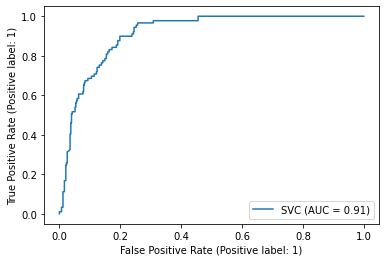

SVM Results:

Accuracy Score: 0.8607350096711799 

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91       428
           1       0.58      0.69      0.63        89

    accuracy                           0.86       517
   macro avg       0.76      0.79      0.77       517
weighted avg       0.87      0.86      0.87       517

Confusion Matrix:
 [[384  44]
 [ 28  61]]


In [36]:
# Split train test
X, y = X_set, y_set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=2, train_size = 0.25)

# Define SVM
clf = svm.SVC(C=1.2,class_weight='balanced', probability = True, kernel = 'linear')

# Fit Model
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Display ROC
metrics.plot_roc_curve(clf, X_test, y_test)  
plt.show()

# Evaluate
print("SVM Results:\n")
print("Accuracy Score:",accuracy_score(y_test,y_pred),"\n")
print("Classification Report:\n",classification_report(y_test, y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

# Importance of  Features

<AxesSubplot:>

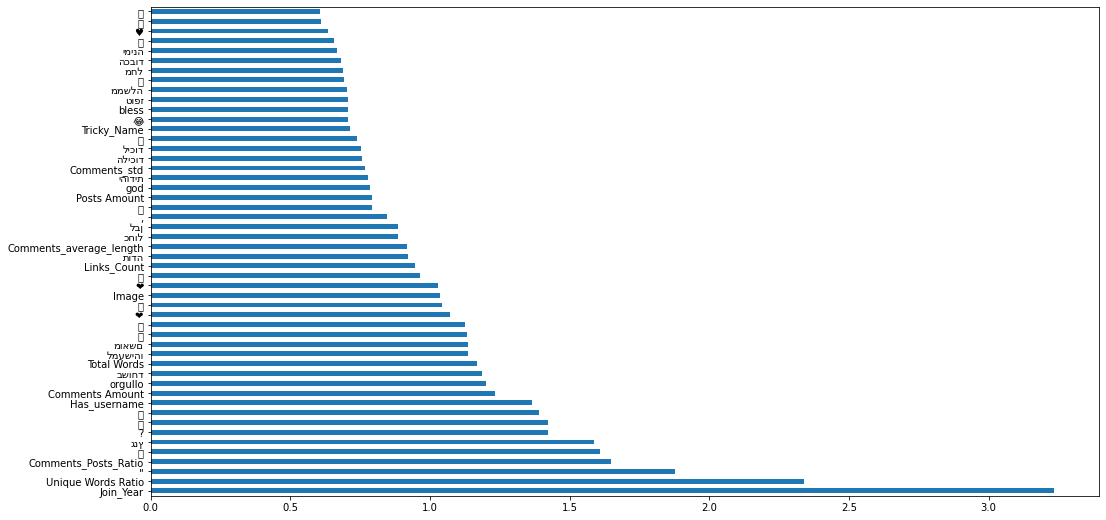

In [39]:
pd.Series(abs(clf_l.coef_[0]), index=X_set.columns).nlargest(50).plot(kind='barh',figsize=(17,9))

In [38]:
sr = pd.Series(abs(clf.coef_[0]), index=X_set.columns).nlargest(50)
for i in sr.index:
    print(i,'\n', round(sr[i],2),'\n')

Join_Year 
 2.11 

Unique Words Ratio 
 1.56 

orgullo 
 1.3 

♥️ 
 1.29 

Has_username 
 1.19 

🎀 
 1.06 

? 
 1.05 

" 
 1.03 

Friends 
 1.03 

Comments Amount 
 0.94 

blue 
 0.86 

, 
 0.8 

Total Words 
 0.8 

Image 
 0.72 

טופז 
 0.68 

Comments_Posts_Ratio 
 0.62 

Tricky_Name 
 0.62 

‼️ 
 0.61 

מענקים 
 0.61 

Comments_average_length 
 0.6 

הממשלה 
 0.59 

🤮 
 0.58 

ליכוד 
 0.56 

Political_Profile_Pic 
 0.54 

/ 
 0.52 

שס 
 0.51 

מחל 
 0.5 

💗 
 0.49 

Followers 
 0.48 

👍 
 0.47 

ימינה 
 0.47 

❤ 
 0.46 

כול 
 0.46 

🐑 
 0.46 

felicidades 
 0.45 

: 
 0.45 

ראש 
 0.44 

💖 
 0.44 

ישראל 
 0.44 

is_heb 
 0.42 

תודה 
 0.42 

🤣 
 0.39 

Unique Words 
 0.39 

השמאל 
 0.38 

📌 
 0.38 

🤝 
 0.38 

💯 
 0.38 

! 
 0.37 

איילת 
 0.37 

🙏 
 0.36 

